In [4]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("./RNN_scripts")
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from RNN_scripts import dms, ranktwo, clustering
from RNN_scripts.modules import LowRankRNN, train
import seaborn as sns

import MARBLE
from MARBLE import utils, geometry, plotting, postprocessing, compare_attractors
from example_utils import generate_trajectories, plot_experiment, aggregate_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
matplotlib.rcParams['figure.figsize'] = (6, 5)
matplotlib.rcParams['font.size'] = 30
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['axes.titlesize'] = 'medium'
matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

# Load trained model

In [6]:
noise_std = 5e-2
alpha = 0.2
hidden_size=500

x_train, y_train, mask_train, x_val, y_val, mask_val = dms.generate_dms_data(1000)
net =  LowRankRNN(2, hidden_size, 1, noise_std, alpha, rank=2)
net.load_state_dict(torch.load(f'./RNN_scripts/dms_rank2_500.pt', map_location='cpu'))
net.svd_reparametrization()

net2 =  LowRankRNN(2, hidden_size, 1, noise_std, alpha, rank=2)
net2.load_state_dict(torch.load(f'./RNN_scripts/dms_rank2_500_2.pt', map_location='cpu'))
net2.svd_reparametrization()

# Visualising two network populations

In [ ]:
n_pops = 2
z, _ = clustering.gmm_fit(net, n_pops, algo='bayes', random_state=2020)  # z will contain labels for the 2 populations

In [ ]:
# Visualizing those 2 populations
m = net.m[:,0].detach().numpy()
n = net.n[:,0].detach().numpy() 
wi1 = net.wi[0].detach().numpy()
wi2 = net.wi[1].detach().numpy()

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
colors = ['rebeccapurple', 'seagreen']
fs = 12
clustering.pop_scatter_linreg(wi1, wi2, z, n_pops, colors=colors, ax=ax[0])
#clustering.pop_scatter_linreg(n, wi1, z, n_pops, colors=colors, ax=ax[0])
clustering.pop_scatter_linreg(n, wi2, z, n_pops, colors=colors, ax=ax[1])
#plt.savefig('./outputs/GNN_parameter_distribution.svg')

# Design input

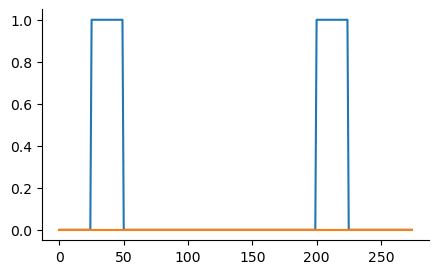

In [7]:
n_gains=20
stim1_begin, stim1_end, stim2_begin, stim2_end, decision = 25, 50, 200, 225, 275
epochs = [0, stim1_begin, stim1_end, stim2_begin, stim2_end, decision]
gain = np.linspace(1,0,n_gains)
    
input = torch.zeros(n_gains, decision, 2)
for i, g in enumerate(gain):
    input[i, stim1_begin:stim1_end, 0] = g
    input[i, stim2_begin:stim2_end, 0] = g
    
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plt.plot(input[0])
#plt.savefig('./outputs/stim.svg')

# Plot phase portraits of two different dynamics  

In [8]:
n_traj=50

traj = generate_trajectories(net, input, epochs, n_traj, fname='./outputs/RNN_trajectories.pkl')
traj2 = generate_trajectories(net2, input, epochs, n_traj, fname='./outputs/RNN_trajectories_2.pkl')

In [ ]:
plot_experiment(net, input, traj, epochs, rect=(-8, 8, -6, 6), traj_to_show=1)

#plt.savefig('./outputs/fields_all_conditions.svg')

In [ ]:
plot_experiment(net2, input, traj2, epochs, rect=(-8, 8, -6, 6), traj_to_show=1)

# Concatenate data and create dataset

In [9]:
pos, vel = aggregate_data(net, traj, epochs)

In [20]:
data = utils.construct_dataset(pos, features=vel, graph_type='cknn', k=15, stop_crit=0.02)

---- Embedding dimension: 3
---- Signal dimension: 3



Computing tangent spaces...: 100%|████████████████████| 20/20 [00:00<00:00, 350.02it/s]



Fraction of variance explained:  tensor([0.5257, 0.8645, 1.0000])

---- Manifold dimension: 3



Computing connections...: 100%|████████████████████████| 20/20 [00:00<00:00, 92.92it/s]


KeyboardInterrupt: 

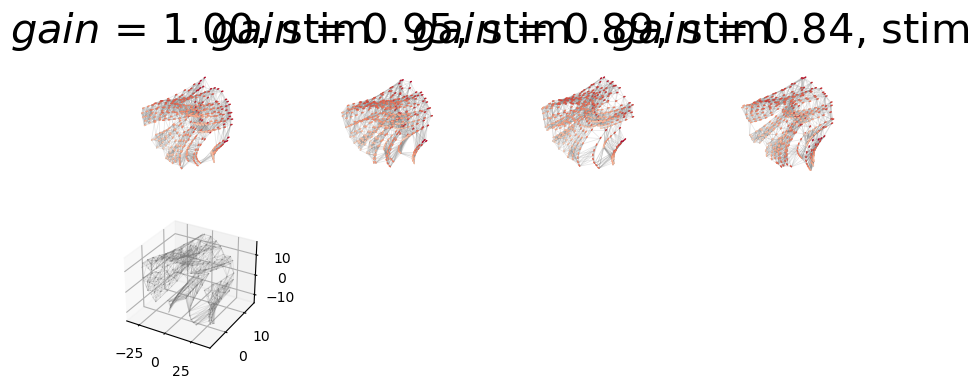

In [21]:
titles = [r'$gain$ = {:0.2f}, {}'.format(g, s) for s in ['stim', 'unstim'] for g in gain ]

plotting.fields(data, col=4, alpha=0.2, width=0.01, scale=200, titles=titles)
plt.show()

In [22]:
par = {'epochs': 100, #optimisation epochs
       'order': 2, #order of derivatives
       'hidden_channels': 32, #number of internal dimensions in MLP
       'out_channels': 3,
       'inner_product_features': True,
      }

model = MARBLE.net(data, **par)
model.run_training(data)


---- Settings: 

epochs : 100
order : 2
hidden_channels : 32
out_channels : 3
inner_product_features : True
batch_size : 64
lr : 0.01
momentum : 0.9
autoencoder : False
diffusion : False
frac_sampled_nb : -1
dropout : 0.0
n_lin_layers : 2
bias : True
vec_norm : False
batch_norm : None
seed : 0
processes : 1
dim_signal : 3
dim_emb : 3
dim_man : 3
n_sampled_nb : -1

---- Number of features to pass to the MLP:  13
---- Total number of parameters:  665

---- Training network ...

Epoch: 1, Training loss: 1.3826, Validation loss: 1.3784, lr: 0.0100 *
Epoch: 2, Training loss: 1.3802, Validation loss: 1.3768, lr: 0.0100 *
Epoch: 3, Training loss: 1.3757, Validation loss: 1.3673, lr: 0.0100 *
Epoch: 4, Training loss: 1.3677, Validation loss: 1.3508, lr: 0.0100 *
Epoch: 5, Training loss: 1.3465, Validation loss: 1.3381, lr: 0.0100 *
Epoch: 6, Training loss: 1.3195, Validation loss: 1.3414, lr: 0.0100
Epoch: 7, Training loss: 1.3234, Validation loss: 1.3532, lr: 0.0100
Epoch: 8, Training loss: 

Performed umap embedding on embedded results.
Performed MDS embedding on embedded results.


<AxesSubplot:>

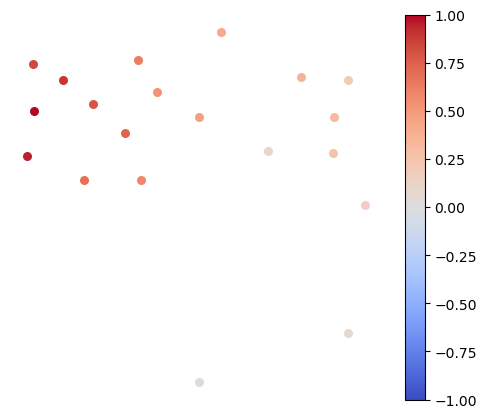

In [27]:
data = model.evaluate(data)
n_clusters=20
data = postprocessing(data, n_clusters=n_clusters)

emb_MDS, _ = geometry.embed(data.dist, embed_typ = 'MDS')
labels = [g for i in range(2) for g in gain ]
plotting.embedding(emb_MDS, labels, s=30, alpha=1)

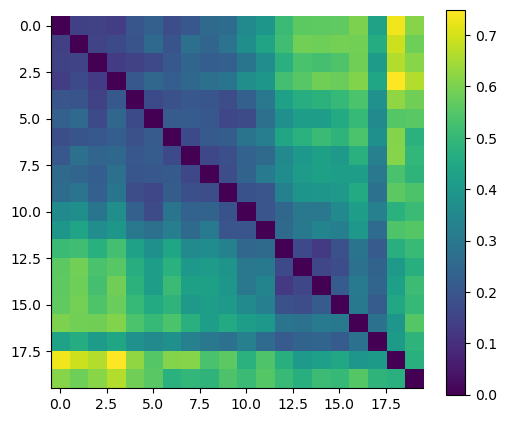

In [26]:
im = plt.imshow(data.dist)
plt.colorbar(im)

# Create new network by fitting Gaussian mixture to the connectivity space

In [ ]:
net_sampled = clustering.to_support_net(net, z, scaling=True)

Check that the resampled networks still give the same validation losses

In [ ]:
accs2 = []
for _ in range(10):
    net_sampled.resample_basis()
    loss, acc = dms.test_dms(net_sampled, x_val, y_val, mask_val)
    accs2.append(acc)

Train net network for a few epochs

In [ ]:
train(net_sampled, x_train, y_train, mask_train, 20, lr=1e-6, resample=True, keep_best=True, clip_gradient=1)

# Plot phase portraits of the resampled system for various parameters

In [ ]:
n_traj=50

traj_sampled = generate_trajectories(net_sampled, input, epochs, n_traj, fname='./outputs/RNN_trajectories_sampled.pkl')
plot_experiment(net_sampled, input, traj_sampled, epochs)

In [ ]:
titles = [r'$gain$ = {:0.2f}, {}'.format(g, s) for s in ['stim', 'unstim'] for g in gain ]
labels = np.hstack([gain,gain])
plotting.embedding(data.emb_2d, data.y.numpy(), titles=titles)